In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.eigenvalues = (s ** 2) / (X.shape[0] - 1)
        self.components = Vt

        if self.n_components is not None:
            self.components = self.components[:self.n_components]
            self.eigenvalues = self.eigenvalues[:self.n_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

X = X / 255.0
X = X[:5000]
y = y[:5000]

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

Dataset shape: (5000, 784)
Labels shape: (5000,)


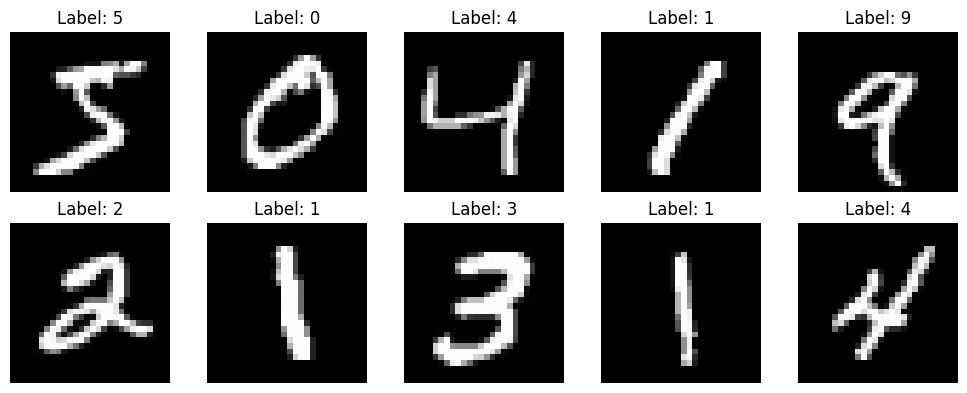

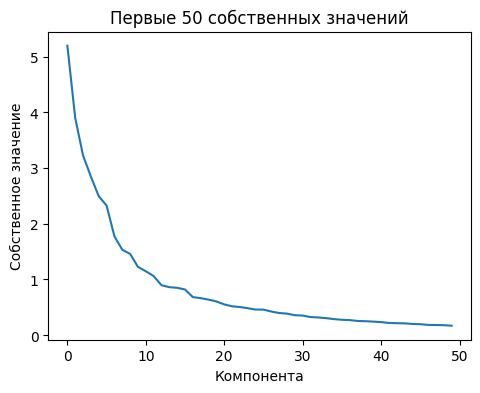

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

pca_full = my_PCA()
pca_full.fit(X)

eigenvalues = pca_full.eigenvalues

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(eigenvalues[:50])
plt.title('Первые 50 собственных значений')
plt.xlabel('Компонента')
plt.ylabel('Собственное значение')

plt.show()

Доля дисперсии первых 30 компонент: 0.736


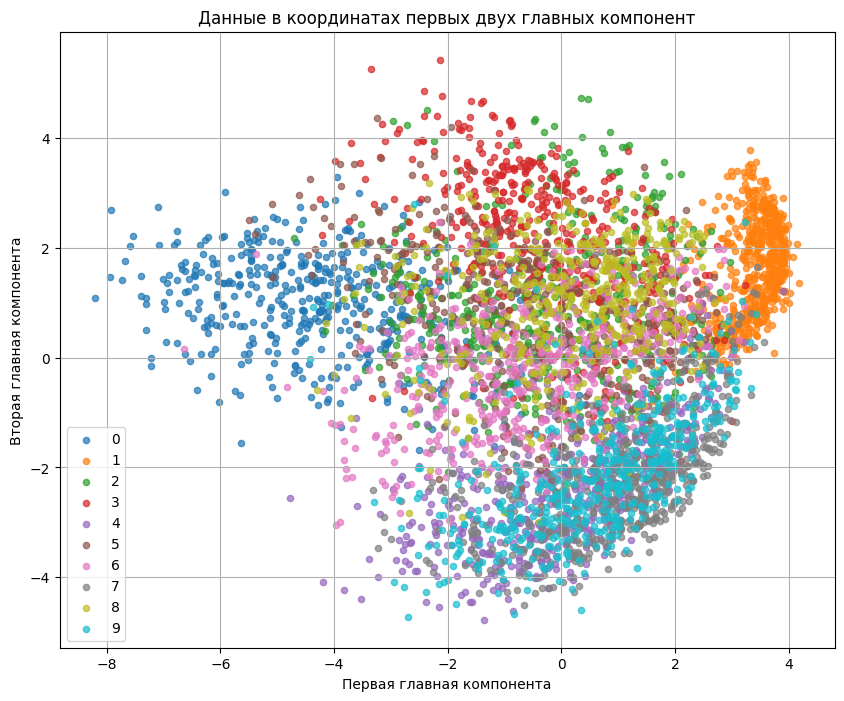

In [5]:
first_30_variance = np.sum(eigenvalues[:30]) / np.sum(eigenvalues)
print(f"Доля дисперсии первых 30 компонент: {first_30_variance:.3f}")

pca_2d = my_PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(10):
    mask = y == i
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=[colors[i]], label=str(i), alpha=0.7, s=20)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Данные в координатах первых двух главных компонент')
plt.legend()
plt.grid(True)
plt.show()

Точность на исходных данных: 0.900
Лучшие параметры: n_components=15, k=1
Лучшая точность: 0.925


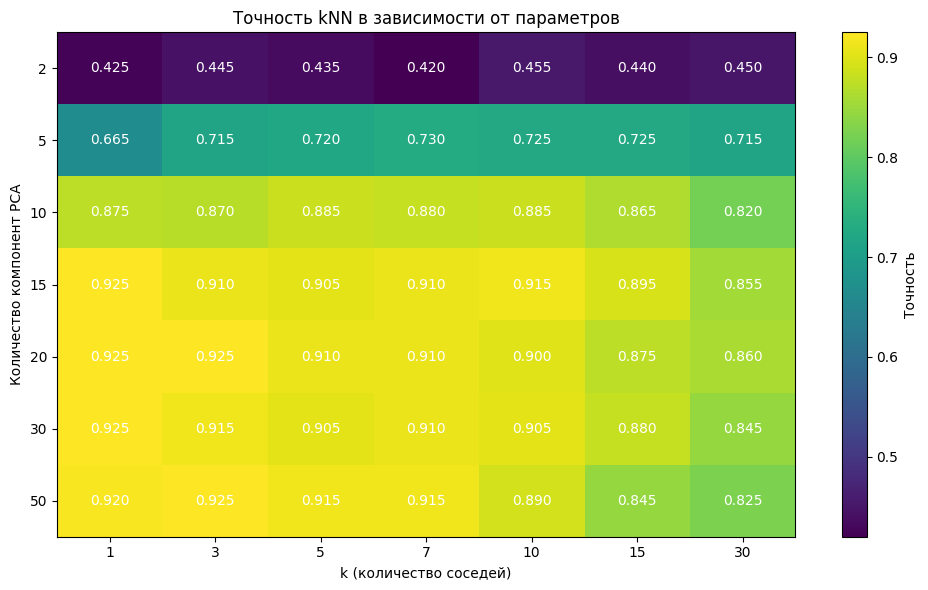


Выводы:
1. Первые 15 главных компонент покрывают 73.6% дисперсии данных
2. Собственные значения связаны с дисперсией - большие значения означают большую вариативность по данному направлению
3. В координатах первых двух главных компонент классы частично разделимы, но есть пересечения
4. Оптимальные параметры: 15 компонент, 1 соседей
5. PCA позволяет значительно сократить размерность при сохранении качества классификации


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

knn = my_kNN(n_neighbors=5)
knn.fit(X_train[:1000], y_train[:1000])
y_pred = knn.predict(X_test[:200])
accuracy_original = accuracy_score(y_test[:200], y_pred)
print(f"Точность на исходных данных: {accuracy_original:.3f}")

n_components_range = [2, 5, 10, 15, 20, 30, 50]
k_range = [1, 3, 5, 7, 10, 15, 30]

best_accuracy = 0
best_n_components = 0
best_k = 0

results = []

for n_comp in n_components_range:
    pca = my_PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for k in k_range:
        knn_pca = my_kNN(n_neighbors=k)
        knn_pca.fit(X_train_pca[:1000], y_train[:1000])
        y_pred_pca = knn_pca.predict(X_test_pca[:200])
        accuracy = accuracy_score(y_test[:200], y_pred_pca)

        results.append({'n_components': n_comp, 'k': k, 'accuracy': accuracy})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_components = n_comp
            best_k = k

print(f"Лучшие параметры: n_components={best_n_components}, k={best_k}")
print(f"Лучшая точность: {best_accuracy:.3f}")

accuracy_matrix = np.zeros((len(n_components_range), len(k_range)))
for result in results:
    i = n_components_range.index(result['n_components'])
    j = k_range.index(result['k'])
    accuracy_matrix[i, j] = result['accuracy']

plt.figure(figsize=(10, 6))
plt.imshow(accuracy_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Точность')
plt.xlabel('k (количество соседей)')
plt.ylabel('Количество компонент PCA')
plt.title('Точность kNN в зависимости от параметров')
plt.xticks(range(len(k_range)), k_range)
plt.yticks(range(len(n_components_range)), n_components_range)
for i in range(len(n_components_range)):
    for j in range(len(k_range)):
        plt.text(j, i, f'{accuracy_matrix[i, j]:.3f}', ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

print("\nВыводы:")
print(f"1. Первые 15 главных компонент покрывают {first_30_variance:.1%} дисперсии данных")
print(f"2. Собственные значения связаны с дисперсией - большие значения означают большую вариативность по данному направлению")
print(f"3. В координатах первых двух главных компонент классы частично разделимы, но есть пересечения")
print(f"4. Оптимальные параметры: {best_n_components} компонент, {best_k} соседей")
print(f"5. PCA позволяет значительно сократить размерность при сохранении качества классификации")